In [2]:
using ITensors

In [8]:
using Plots

In [59]:
using SparseArrays, LinearAlgebra, Arpack, LsqFit

In [5]:
function Calc_SvN(psi::MPS, b::Int64)
    # Orthogonalize the MPS at bond index b
    orthogonalize!(psi, b)

    # Perform Singular Value Decomposition (SVD)
    U, S, V = svd(psi[b], (linkind(psi, b-1), siteind(psi, b)))

    # Calculate von Neumann entropy
    SvN = 0.0
    for n = 1:dim(S, 1)
        p = S[n, n]^2
        SvN -= p * log(p)
    end

    return SvN
end;

In [6]:
function TFIM_DMRG(N::Int64, h::Float64, swp_num::Int64, maxM::Int64)
"""
    TFIM_DMRG(N::Int64, h::Float64, swp_num::Int64, maxM::Int64)

    Perform a Density Matrix Renormalization Group (DMRG) simulation for the Transverse Field Ising Model (TFIM) on a 1D chain.

    Parameters:
    - `N::Int64`: Number of sites in the 1D quantum system.
    - `h::Float64`: Transverse field strength in the TFIM Hamiltonian.
    - `swp_num::Int64`: Number of DMRG sweeps.
    - `maxM::Int64`: Maximum bond dimension.

    Returns:
    - `energy::Float64`: Ground state energy obtained from the DMRG simulation.
    - `psi::MPS`: Matrix Product State (MPS) representing the ground state of the quantum system after DMRG.
"""
    # Generate an index set representing quantum sites with spin S=1/2
    sites = siteinds("S=1/2", N)

    # Initialize an operator sum representing the Hamiltonian using ITensors
    ampo = OpSum()

    # Construct the Hamiltonian operator for the TFIM
    for j = 1:N
        if j < N
            # Interaction term between neighboring spins (Sz-Sz)
            ampo += -2.0, "Sz", j, "Sz", j + 1
        end
        # Transverse field term (Sx) at each site
        ampo += -h, "Sx", j
    end

    # Convert the operator sum to a Matrix Product Operator (MPO)
    H = MPO(ampo, sites)

    # Initialize the initial state to a random maxM=10 state 
    psi0 = randomMPS(sites,10)

    # Set up parameters for the DMRG (Density Matrix Renormalization Group) algorithm
    sweeps = Sweeps(swp_num)
    setmaxdim!(sweeps, maxM)
    setcutoff!(sweeps, 1E-16)

    # Perform the DMRG simulation to obtain the ground state energy and MPS representation
    energy, psi = dmrg(H, psi0, sweeps)

    return energy, psi
end;

In [7]:
N = 40
h = 0.1
swp_num = 20
maxM = 20
energy, psi = TFIM_DMRG(N, h, swp_num, maxM);

After sweep 1 energy=-19.552487159036072  maxlinkdim=20 maxerr=6.72E-11 time=24.199
After sweep 2 energy=-19.552534465172567  maxlinkdim=16 maxerr=2.54E-14 time=0.084
After sweep 3 energy=-19.552534465211917  maxlinkdim=3 maxerr=9.57E-17 time=0.055
After sweep 4 energy=-19.552534465211927  maxlinkdim=3 maxerr=6.63E-17 time=0.077
After sweep 5 energy=-19.552534465211938  maxlinkdim=3 maxerr=6.63E-17 time=0.046
After sweep 6 energy=-19.552534465211938  maxlinkdim=3 maxerr=6.63E-17 time=0.045
After sweep 7 energy=-19.552534465211938  maxlinkdim=3 maxerr=6.63E-17 time=0.055
After sweep 8 energy=-19.552534465211938  maxlinkdim=3 maxerr=6.63E-17 time=0.056
After sweep 9 energy=-19.552534465211938  maxlinkdim=3 maxerr=6.63E-17 time=0.083
After sweep 10 energy=-19.552534465211938  maxlinkdim=3 maxerr=6.63E-17 time=0.044
After sweep 11 energy=-19.552534465211938  maxlinkdim=3 maxerr=6.63E-17 time=0.048
After sweep 12 energy=-19.552534465211938  maxlinkdim=3 maxerr=6.63E-17 time=0.061
After swee

# 1. J1-J2 spin 1/2 chain

##     1. Heisenberg Hamiltonian construction for finite J2 term

Using

$\vec{S_{i}\cdot}\vec{S}_{j}=S_{i}^{z}S_{j}^{z}+\frac{1}{2}(S_{i}^{+}S_{j}^{-}+S_{i}^{-}S_{j}^{+})$

The hamiltonian gets the form

$ H=J_{1}\sum_{i}\vec{S_{i}\cdot}\vec{S}_{i+1}+J_{2}\sum_{i}\vec{S_{i}}\cdot\vec{S_{i+2}}$

$    =J_{1}\sum_{i}\left(S_{i}^{z}S_{i+1}^{z}+\frac{1}{2}(S_{i}^{+}S_{i+1}^{-}+S_{i}^{-}S_{i+1}^{+})\right)+J_{2}\sum_{i}\left(S_{i}^{z}S_{i+2}^{z}+\frac{1}{2}(S_{i}^{+}S_{i+2}^{-}+S_{i}^{-}S_{i+2}^{+})\right) $

Generalization of the method seen in class 6 for the MPO will lead to the matrices


$W_{(L)}=\left(\begin{array}{c}
I\\
S^{z}\\
S^{+}\\
S^{-}\\
0\\
0\\
0\\
0
\end{array}\right)$

$W_{(i)}=\left(\begin{array}{cccccccc}
I & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
S^{z} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
S^{+} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
S^{-} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & I & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & I & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & I & 0 & 0 & 0 & 0\\
0 & J_{1}S^{z} & \frac{J_{1}}{2}S^{-} & \frac{J_{1}}{2}S^{+} & J_{2}S^{z} & \frac{J_{2}}{2}S^{-} & \frac{J_{2}}{2}S^{+} & I
\end{array}\right)$

$W_{(1)}=\left(\begin{array}{cccccccc}
0 & J_{1}S^{z} & \frac{J_{1}}{2}S^{-} & \frac{J_{1}}{2}S^{+} & J_{2}S^{z} & \frac{J_{2}}{2}S^{-} & \frac{J_{2}}{2}S^{+} & I\end{array}\right)$

In [44]:
function J1J2_DMRG(N::Int64, J1::Float64, J2::Float64, swp_num::Int64, maxM::Int64, QN_subspace::Int64)
    
    # Generate an index set representing quantum sites with spin S=1/2
    sites = siteinds("S=1/2", N; conserve_qns=true)

    # Initialize an operator sum representing the Hamiltonian using ITensors
    ampo = OpSum()

    # Construct the Hamiltonian operator for the TFIM
    for j = 1:N
        if j < N
            # Interaction term between neighboring spins (Sz-Sz)
            ampo += J1, "Sz", j, "Sz", j + 1
            ampo += J1/2, "S+", j, "S-", j + 1 
            ampo += J1/2, "S-", j, "S+", j + 1
        end
        if j < N-1
            # Interaction term between second neighboring spins (Sz-Sz)
            ampo += J2, "Sz", j, "Sz", j + 2
            ampo += J2/2, "S+", j, "S-", j + 2 
            ampo += J2/2, "S-", j, "S+", j + 2
        end 
    end

    # Convert the operator sum to a Matrix Product Operator (MPO)
    H = MPO(ampo, sites)

    # Initialize the initial state to a random maxM=10 state 
    #psi0 = randomMPS(sites,10)
    state= [isodd(n) ? "Up" : "Dn" for n=1:N]
    if QN_subspace == 1
        state[2]="Up"
    end
    psi0 = MPS(sites,state)
    
    # Set up parameters for the DMRG (Density Matrix Renormalization Group) algorithm
    sweeps = Sweeps(swp_num)
    setmaxdim!(sweeps, maxM)
    setcutoff!(sweeps, 1E-16)

    # Perform the DMRG simulation to obtain the ground state energy and MPS representation
    energy, psi = dmrg(H, psi0, sweeps)

    return energy, psi
end;

## 2. Finite size scaling

In [48]:
function finite_size_scaling(N_arr,g,swp_num,maxM)
    delta_arr=[]
    J1=1.
    J2=g*J1
    for N in N_arr
        energy_s0, psi_0 = J1J2_DMRG(N, J1, J2, swp_num, maxM,0);
        energy_s1, psi_1 = J1J2_DMRG(N, J1, J2, swp_num, maxM,1);
        push!(delta_arr, energy_s1-energy_s0)
    end
    return delta_arr
end;

In [49]:
N_arr= [ n for n in 20:20:100];
swp_num = 10
maxM = 100;

In [50]:
g_arr=[0 ,0.241, 0.48]
deltas_g_arr=[]
for g in g_arr
    push!(deltas_g_arr,finite_size_scaling(N_arr,g,swp_num,maxM))
end;

After sweep 1 energy=-8.60514183065435  maxlinkdim=4 maxerr=0.00E+00 time=0.042
After sweep 2 energy=-8.681922609869904  maxlinkdim=16 maxerr=0.00E+00 time=0.156
After sweep 3 energy=-8.682473323653621  maxlinkdim=64 maxerr=8.77E-17 time=0.121
After sweep 4 energy=-8.68247333439891  maxlinkdim=99 maxerr=9.81E-17 time=0.251
After sweep 5 energy=-8.682473334398972  maxlinkdim=97 maxerr=1.04E-16 time=0.257
After sweep 6 energy=-8.682473334398976  maxlinkdim=97 maxerr=8.94E-17 time=0.263
After sweep 7 energy=-8.682473334398955  maxlinkdim=97 maxerr=8.94E-17 time=0.268
After sweep 8 energy=-8.682473334398965  maxlinkdim=97 maxerr=8.94E-17 time=0.298
After sweep 9 energy=-8.682473334398964  maxlinkdim=97 maxerr=8.94E-17 time=0.294
After sweep 10 energy=-8.68247333439896  maxlinkdim=97 maxerr=8.94E-17 time=0.265
After sweep 1 energy=-7.910060820117726  maxlinkdim=4 maxerr=0.00E+00 time=0.062
After sweep 2 energy=-8.479555924186457  maxlinkdim=16 maxerr=0.00E+00 time=0.101
After sweep 3 energy

After sweep 10 energy=-44.08729916754671  maxlinkdim=100 maxerr=1.76E-10 time=2.424
After sweep 1 energy=-7.893031868110662  maxlinkdim=4 maxerr=0.00E+00 time=0.078
After sweep 2 energy=-7.94944575912862  maxlinkdim=16 maxerr=0.00E+00 time=0.129
After sweep 3 energy=-7.94978613502113  maxlinkdim=64 maxerr=9.98E-17 time=0.249
After sweep 4 energy=-7.949786241657115  maxlinkdim=100 maxerr=6.60E-16 time=0.392
After sweep 5 energy=-7.949786241662649  maxlinkdim=100 maxerr=2.41E-16 time=0.464
After sweep 6 energy=-7.949786241662642  maxlinkdim=100 maxerr=1.70E-16 time=0.403
After sweep 7 energy=-7.949786241662626  maxlinkdim=100 maxerr=1.70E-16 time=0.435
After sweep 8 energy=-7.949786241662648  maxlinkdim=100 maxerr=1.70E-16 time=0.483
After sweep 9 energy=-7.949786241662641  maxlinkdim=100 maxerr=1.70E-16 time=0.461
After sweep 10 energy=-7.949786241662631  maxlinkdim=100 maxerr=1.70E-16 time=0.477
After sweep 1 energy=-7.267425336676245  maxlinkdim=4 maxerr=0.00E+00 time=0.087
After swee

After sweep 9 energy=-40.06545406548293  maxlinkdim=100 maxerr=8.84E-11 time=6.043
After sweep 10 energy=-40.06553217396506  maxlinkdim=100 maxerr=5.58E-11 time=5.755
After sweep 1 energy=-7.49616712208073  maxlinkdim=4 maxerr=0.00E+00 time=0.080
After sweep 2 energy=-7.503861902049232  maxlinkdim=16 maxerr=0.00E+00 time=0.144
After sweep 3 energy=-7.503869774420087  maxlinkdim=64 maxerr=7.84E-17 time=0.280
After sweep 4 energy=-7.503869788818607  maxlinkdim=100 maxerr=3.64E-16 time=0.475
After sweep 5 energy=-7.503869788823641  maxlinkdim=91 maxerr=2.01E-16 time=0.497
After sweep 6 energy=-7.503869788823639  maxlinkdim=86 maxerr=9.98E-17 time=0.447
After sweep 7 energy=-7.503869788823646  maxlinkdim=86 maxerr=9.94E-17 time=0.446
After sweep 8 energy=-7.503869788823656  maxlinkdim=86 maxerr=9.94E-17 time=0.440
After sweep 9 energy=-7.503869788823648  maxlinkdim=86 maxerr=9.94E-17 time=0.433
After sweep 10 energy=-7.503869788823638  maxlinkdim=86 maxerr=9.94E-17 time=0.412
After sweep 1

After sweep 8 energy=-37.30391943337031  maxlinkdim=100 maxerr=4.45E-11 time=4.347
After sweep 9 energy=-37.30837316989935  maxlinkdim=100 maxerr=6.28E-11 time=4.198
After sweep 10 energy=-37.31212928522433  maxlinkdim=100 maxerr=8.88E-11 time=4.384


For g=0:

In [61]:
g=0
x = 1 ./ N_arr
y = deltas_g_arr[1]

fun(x, a) = a[1] .+ a[2]*x
res = LsqFit.curve_fit(fun, x, y, [0., 0.])

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Any}, Vector{LsqFit.LMState{LsqFit.LevenbergMarquardt}}}([0.006985882985487524, 3.4781646074797927], [0.0007994770073661839, -0.001908419094258082, -0.0006739397857397772, 0.0004560552069854465, 0.0013268266658226086], [1.000000000000636 0.049999999999968646; 1.000000000000636 0.024999999999984323; … ; 0.9999999999994902 0.012499999999992161; 1.000000000000636 0.010000000000158455], true, Iter     Function value   Gradient norm 
------   --------------   --------------
, Any[])

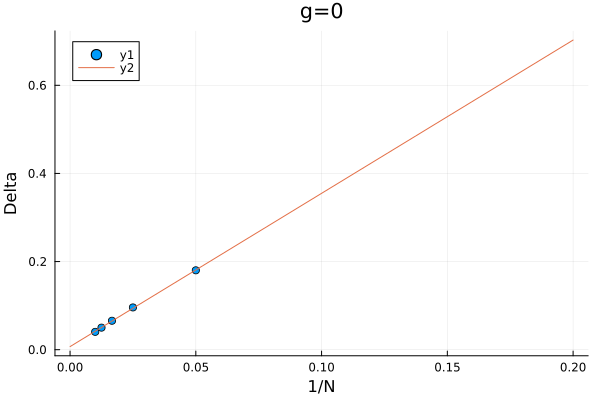

In [78]:
scatter(x, y,linestyle = :dot,title="g=0",xlabel="1/N",ylabel= "Delta")
plot!(x1, fun(x1, coef(res)))

In [81]:
intercept=coef(res)[1]
println("The intercept for g=0 is $intercept")

The intercept for g=0 is 0.006985882985487524


Which is pretty close to zero, indicating the system is gapless as expected

For g=g_c=0.241

In [85]:
g=0.241
x = 1 ./ N_arr
y = deltas_g_arr[2]

fun(x, a) = a[1] .+ a[2]*x
res = LsqFit.curve_fit(fun, x, y, [0., 0.]);

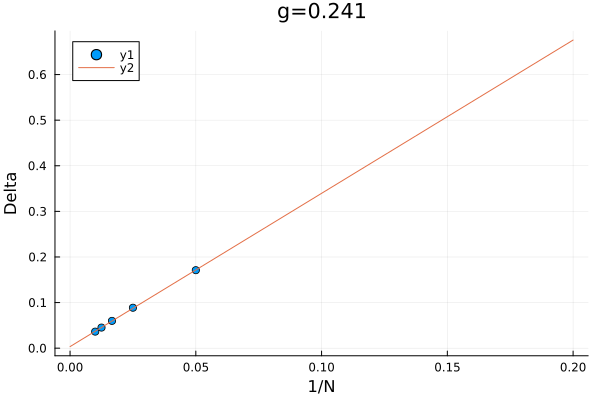

In [86]:
scatter(x, y,linestyle = :dot,title="g=0.241",xlabel="1/N",ylabel= "Delta")
plot!(x1, fun(x1, coef(res)))

In [87]:
intercept=coef(res)[1]
println("The intercept for g=0 is $intercept")

The intercept for g=0 is 0.003511926213340998


Which is pretty close to zero, indicating the system is gapless as expected for still being in the phase with g below gc

For g=0.48:

In [100]:
g=0.48
x = 1 ./ N_arr
y = deltas_g_arr[3]

fun(x, a) = a[1] .+ a[2]*x .+ a[3]*(x.^2)
res = LsqFit.curve_fit(fun, x, y, [0., 0., 0.]);

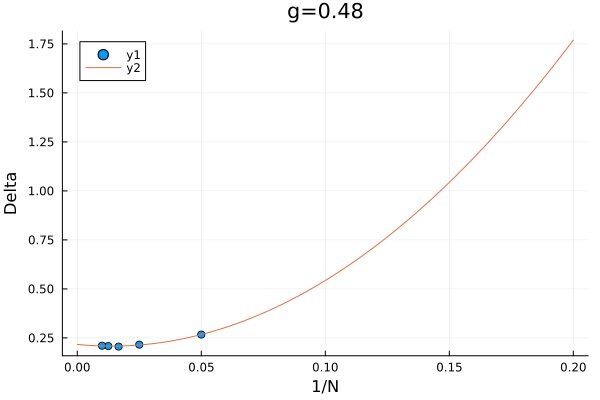

In [101]:
scatter(x, y,linestyle = :dot,title="g=0.48",xlabel="1/N",ylabel= "Delta")
plot!(x1, fun(x1, coef(res)))

Here we can see an obvious finite gap as expected from being deep in the dimerized phase

## 3. Spin-spin correlations

In [110]:
x_arr= [x for x in 1:200];

In [102]:
N = 200
swp_num = 10
maxM = 100
J1=1.0;

For g=0:

In [171]:
g=0.
energy_s0_g0, psi_0_g0 = J1J2_DMRG(N, J1,J1*g , swp_num, maxM,0)
corr_mat_g0 = correlation_matrix(psi_0_g0,"Sz","Sz");

After sweep 1 energy=-87.90732132925154  maxlinkdim=4 maxerr=0.00E+00 time=0.652
After sweep 2 energy=-88.40009736494895  maxlinkdim=16 maxerr=0.00E+00 time=1.194
After sweep 3 energy=-88.4367923683276  maxlinkdim=64 maxerr=9.54E-17 time=1.950
After sweep 4 energy=-88.44026222450567  maxlinkdim=100 maxerr=3.54E-11 time=3.997
After sweep 5 energy=-88.4412149980951  maxlinkdim=100 maxerr=3.27E-10 time=5.077
After sweep 6 energy=-88.44152457900702  maxlinkdim=100 maxerr=2.73E-09 time=5.257
After sweep 7 energy=-88.44155419065386  maxlinkdim=100 maxerr=3.52E-09 time=5.306
After sweep 8 energy=-88.44155471067545  maxlinkdim=100 maxerr=2.85E-09 time=5.143
After sweep 9 energy=-88.44155471372999  maxlinkdim=100 maxerr=2.80E-09 time=6.679
After sweep 10 energy=-88.44155471369858  maxlinkdim=100 maxerr=2.81E-09 time=5.192


In [211]:
x = x_arr[100:end] .- 100
y = abs.(corr_mat_g0[100,100:end])

fun(x, a) = x.^a[1]
res = LsqFit.curve_fit(fun, x, y, [-2.]);

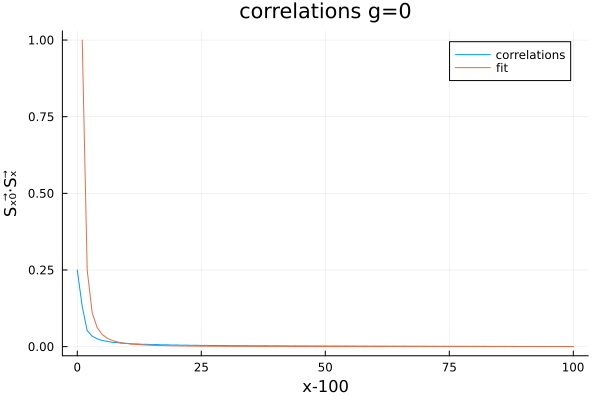

In [216]:
plot(x,y,xlabel="x-100",ylabel="Sₓ₀⃗⋅Sₓ⃗",title="correlations g=0",label="correlations")
plot!(x , fun(x, coef(res)),label="fit")

For g=g_c=0.241

In [152]:
g=0.241
energy_s0_gc, psi_0_gc = J1J2_DMRG(N, J1, J1*g, swp_num, maxM,0)
corr_mat_gc = correlation_matrix(psi_0_gc,"Sz","Sz");

After sweep 1 energy=-79.85921543022567  maxlinkdim=4 maxerr=0.00E+00 time=0.738
After sweep 2 energy=-80.26699841583698  maxlinkdim=16 maxerr=0.00E+00 time=1.569
After sweep 3 energy=-80.29225473086893  maxlinkdim=64 maxerr=9.76E-17 time=3.004
After sweep 4 energy=-80.29554791426227  maxlinkdim=100 maxerr=1.74E-11 time=7.493
After sweep 5 energy=-80.29686267966746  maxlinkdim=100 maxerr=9.10E-11 time=9.498
After sweep 6 energy=-80.297547509049  maxlinkdim=100 maxerr=9.18E-11 time=9.500
After sweep 7 energy=-80.29800930601232  maxlinkdim=100 maxerr=3.59E-10 time=9.504
After sweep 8 energy=-80.2981796706352  maxlinkdim=100 maxerr=5.79E-10 time=10.391
After sweep 9 energy=-80.2982279430498  maxlinkdim=100 maxerr=4.67E-09 time=9.374
After sweep 10 energy=-80.29823344141123  maxlinkdim=100 maxerr=4.83E-09 time=9.081


In [214]:
x = x_arr[100:end] .- 100
y = abs.(corr_mat_gc[100,100:end])

fun(x, a) = x.^a[1]
res = LsqFit.curve_fit(fun, x, y, [-2.]);

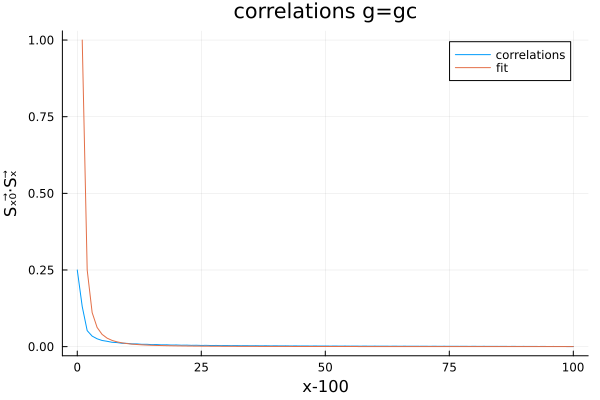

In [215]:
plot(x,y,xlabel="x-100",ylabel="Sₓ₀⃗⋅Sₓ⃗",title="correlations g=gc",label="correlations")
plot!(x , fun(x, coef(res)),label="fit")

For g=0.48:

In [106]:
g=0.48
energy_s0_gbig, psi_0_gbig = J1J2_DMRG(N, J1, J1*g, swp_num, maxM,0)
corr_mat_gbig = correlation_matrix(psi_0_gbig,"Sz","Sz");

After sweep 1 energy=-74.86128782590902  maxlinkdim=4 maxerr=0.00E+00 time=1.156
After sweep 2 energy=-75.04518564982467  maxlinkdim=16 maxerr=0.00E+00 time=2.533
After sweep 3 energy=-75.04545075719118  maxlinkdim=64 maxerr=9.99E-17 time=3.322
After sweep 4 energy=-75.04545397642252  maxlinkdim=100 maxerr=2.90E-15 time=8.713
After sweep 5 energy=-75.04545451340503  maxlinkdim=100 maxerr=2.56E-14 time=9.508
After sweep 6 energy=-75.04545469548424  maxlinkdim=100 maxerr=3.99E-15 time=9.114
After sweep 7 energy=-75.04545473347615  maxlinkdim=100 maxerr=2.13E-15 time=8.832
After sweep 8 energy=-75.04545474049236  maxlinkdim=100 maxerr=5.53E-15 time=9.522
After sweep 9 energy=-75.04545474163356  maxlinkdim=100 maxerr=3.11E-15 time=9.080
After sweep 10 energy=-75.0454547417934  maxlinkdim=100 maxerr=2.78E-15 time=10.233


In [220]:
x = x_arr[100:end] .- 100
y = abs.(corr_mat_gbig[100,100:end])

fun(x, a) = exp.(-x./a[1])
res = LsqFit.curve_fit(fun, x, y, [1.]);

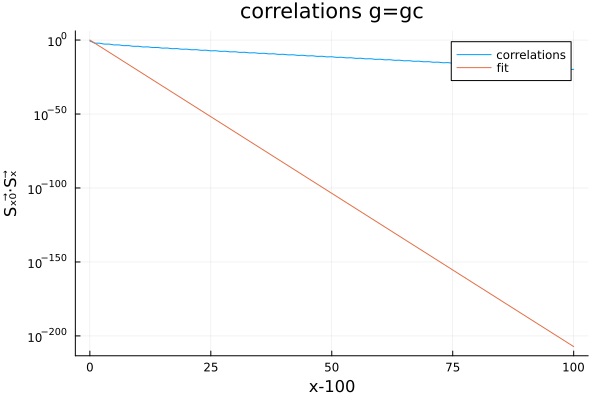

In [222]:
plot(x,y,xlabel="x-100",ylabel="Sₓ₀⃗⋅Sₓ⃗",title="correlations g=gc",label="correlations")
plot!(x , fun(x, coef(res)),label="fit",yscale=:log10)

# 2. spin-1 - Haldane gap

In [10]:
function bilinear_biquadtatic_DMRG(N::Int64, J1::Float64, J2::Float64, swp_num::Int64, maxM::Int64)
    
    # Generate an index set representing quantum sites with spin S=1/2
    sites = siteinds("S=1/2", N)

    # Initialize an operator sum representing the Hamiltonian using ITensors
    ampo = OpSum()

    # Construct the Hamiltonian operator for the TFIM
    for j = 1:N-1
        # Interaction term between neighboring spins (Sz-Sz)
        ampo += J1, "Sz", j, "Sz", j + 1
        ampo += J1/2, "S+", j, "S-", j + 1
        ampo += J1/2, "S-", j, "S+", j + 1
        
        #J2 
        ampo += J2, "Sz", j, "Sz", j + 1, "Sz", j, "Sz", j + 1
        ampo += J2/4, "S+", j, "S-", j + 1, "S-", j, "S+", j + 1
        ampo += J2/4, "S-", j, "S+", j + 1, "S+", j, "S-", j + 1
        ampo += J2/4, "S+", j, "S-", j + 1, "S+", j, "S-", j + 1
        ampo += J2/4, "S-", j, "S+", j + 1, "S-", j, "S+", j + 1
        ampo += J1/2, "S-", j, "S+", j + 1, "Sz", j, "Sz", j + 1
        ampo += J1/2, "S+", j, "S-", j + 1, "Sz", j, "Sz", j + 1
        ampo += J1/2, "Sz", j, "Sz", j + 1, "S-", j, "S+", j + 1
        ampo += J1/2, "Sz", j, "Sz", j + 1, "S+", j, "S-", j + 1
    end

    # Convert the operator sum to a Matrix Product Operator (MPO)
    H = MPO(ampo, sites)

    # Initialize the initial state to a random maxM=10 state 
    psi0 = randomMPS(sites,10)

    # Set up parameters for the DMRG (Density Matrix Renormalization Group) algorithm
    sweeps = Sweeps(swp_num)
    setmaxdim!(sweeps, maxM)
    setcutoff!(sweeps, 1E-16)

    # Perform the DMRG simulation to obtain the ground state energy and MPS representation
    energy, psi = dmrg(H, psi0, sweeps)

    return energy, psi
end;